In [1]:
import pymysql
from pymysql.err import MySQLError
import missingno as msn
import pandas as pd
import csv
from datetime import datetime
import phonenumbers
from phonenumbers import NumberParseException, PhoneNumberFormat

# Check connection and database

In [2]:
mydb = pymysql.connect(
    host="localhost",
    user="root",
    password="First@445",
    database="Sale"
)
print("Connected with IPL Database")

mydb.close()

Connected with IPL Database


# Reading file and data cleaning

In [3]:
# import the file
df=pd.read_csv(r"C:\Users\Kamalachandran\Desktop\Intern\task\task 6\sales_data.csv")
print(df.shape)

(2823, 25)


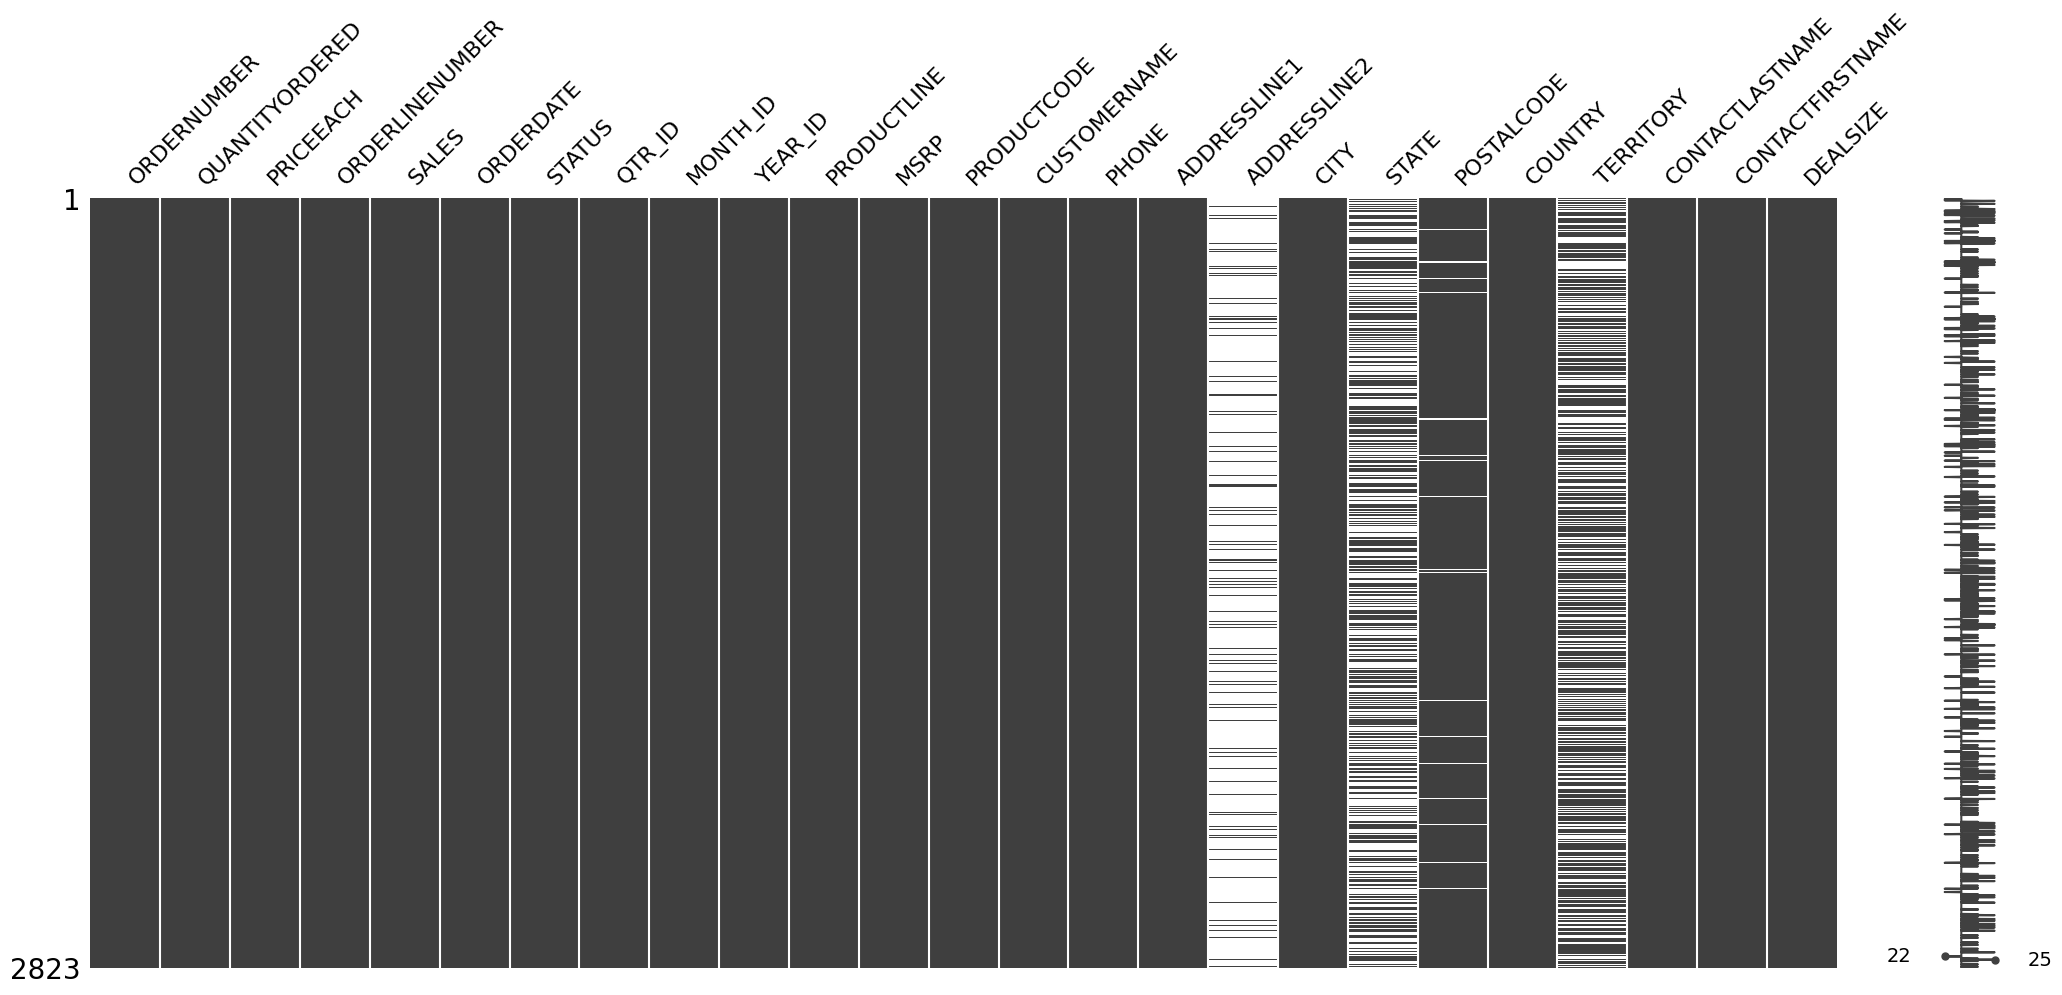

In [4]:
msn.matrix(df);

In [5]:
df.drop(['ADDRESSLINE2'], axis=1, inplace=True)

In [6]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [7]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")

In [8]:
# make more readable
rename_dict = {
    "ORDERNUMBER": "order_number",
    "QUANTITYORDERED": "quantity_ordered",
    "PRICEEACH": "price_each",
    "ORDERLINENUMBER": "order_line_number",
    "SALES": "sales",
    "ORDERDATE": "order_date",
    "STATUS": "status",
    "QTR_ID": "quarter_id",
    "MONTH_ID": "month_id",
    "YEAR_ID": "year_id",
    "PRODUCTLINE": "product_line",
    "MSRP": "msrp",
    "PRODUCTCODE": "product_code",
    "CUSTOMERNAME": "customer_name",
    "PHONE": "phone",
    "ADDRESSLINE1": "address_line",
    "CITY": "city",
    "STATE": "state",
    "POSTALCODE": "postal_code",
    "COUNTRY": "country",
    "TERRITORY": "territory",
    "CONTACTLASTNAME": "contact_last_name",
    "CONTACTFIRSTNAME": "contact_first_name",
    "DEALSIZE": "deal_size"
}

# Apply rename
df = df.rename(columns=rename_dict)

In [9]:
#Standardize text fields
df["status"] = df["status"].str.strip().str.upper()
df["country"] = df["country"].str.strip().str.title()
df["state"] = df["state"].fillna("").str.upper()
df["city"] = df["city"].str.title()

# convert datatype year/month/quarter to integers
df["year_id"] = df["year_id"].astype(int)
df["month_id"] = df["month_id"].astype(int)
df["quarter_id"] = df["quarter_id"].astype(int)

In [10]:
# Convert data types
df["order_number"] = df["order_number"].astype(int)
df["quantity_ordered"] = df["quantity_ordered"].astype(int)
df["order_line_number"] = df["order_line_number"].astype(int)

df["price_each"] = df["price_each"].astype(float)
df["sales"] = df["sales"].astype(float)

df["postal_code"] = df["postal_code"].astype(str)

In [11]:
df['phone'] = df['phone'].str.replace(r"[.\s]", "", regex=True)

In [12]:
def format_phone_number(number, default_region='US'):
    try:
        number = number.replace(".", "").replace("(", "").replace(")", "").replace(" ", "")
        parsed = phonenumbers.parse(str(number), default_region)
        if phonenumbers.is_valid_number(parsed):
            return str(parsed.national_number)
        else:
            return None
    except NumberParseException:
        return None

df['phone'] = df['phone'].apply(format_phone_number)

In [13]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


print(f"DataFrame shape before removing duplicates: {df.shape}")

df = df.drop_duplicates()
print(f"DataFrame shape after removing duplicates: {df.shape}")


Number of duplicate rows: 0
DataFrame shape before removing duplicates: (2823, 24)
DataFrame shape after removing duplicates: (2823, 24)


In [14]:
df["order_date"] = pd.to_datetime(df["order_date"])
df["order_date"] = df["order_date"].dt.strftime("%Y-%m-%d")

# Insert values to SQL table

In [15]:
try:
    # Connect to database
    mydb = pymysql.connect(
        host="localhost",
        user="root",
        password="First@445",
        database="sale"
    )
    print("Connected successfully!")

    cursor = mydb.cursor()

    # Example insert query (adjust to match your matches table!)
    insert_query = """
    INSERT INTO sale (order_number, quantity_ordered, price_each, order_line_number, sales,
    order_date, status, quarter_id, month_id, year_id, product_line, msrp, product_code,
    customer_name, phone, address_line, city, state, postal_code, country, territory,
    contact_last_name, contact_first_name, deal_size)

    VALUES (%s, %s, %s, %s, %s,%s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

    # Suppose df is your DataFrame
    data = [tuple(row) for row in df.to_numpy()]
    
    cursor.executemany(insert_query, data)
    
    mydb.commit()

    print(f"{cursor.rowcount} rows inserted successfully!")

except MySQLError as e:
    print("SQL error:", e)

finally:
    if cursor:
        cursor.close()
    if mydb:
        mydb.close()


Connected successfully!
2823 rows inserted successfully!
